<h1 align=center><font size = 5>Detect the fraudulent E-payment transactions by using supervised machine learning models</font></h1>

## Table of Contents

<div class="alert alert-block alert-info" style="margin-top: 20px">

<font size = 3>

<a href=#aboutdataset>About the Dataset</a>

<a href=#DataExploration>Data Exploration</a>

<a href=#DataProcessing>Data Processing</a>

<a href=#hotencoding>Hot Encoding</a>

<a href=#splitingdata>Spliting Data</a>
    

<a href=#Trainingdataset>Training Dataset</a>
    
<a href=#oversampling>Oversampling</a>
 <br>
 
   
    

<a href=#catboost>CatBoost Model</a>
    
<a href=#adaboost>AdaBoost Model</a>
    
<a href=#lgbboost>LGBBoost Model</a>
    
<a href=#xgbboost>XGBBoost Model</a>
    
<a href=#knn>KNeighbors Model</a>
    

    
<a href=#results>Results</a> 
    
<a href=#discussion>Discussion</a>    

<a href=#recomendation>Recomendation</a> 
    
</font>
</div>

<a name='aboutdataset'/>
About the Dataset

<b> Data Source</b>
https://www.kaggle.com/ntnu-testimon/banksim1

<b>Context</b><br>
BankSim is an agent-based simulator of bank payments based on a sample of aggregated transactional data provided by a bank in Spain. The main purpose of BankSim is the generation of synthetic data that can be used for fraud detection research. Statistical and a Social Network Analysis (SNA) of relations between merchants and customers were used
to develop and calibrate the model. Our ultimate goal is for BankSim to be usable to model relevant scenarios that combine normal payments and injected known fraud signatures. The data sets generated by BankSim contain no personal information or disclosure of legal and private customer transactions. Therefore, it can be shared by academia, and others, to develop and reason about fraud detection methods. Synthetic data has the added benefit of being easier to acquire, faster and at less cost, for experimentation even for those that have access to their own data. We argue that BankSim generates data that usefully approximates the relevant aspects of the real data.

<b>Content</b><br>
We ran BankSim for 180 steps (approx. six months), several times and calibrated the parameters in order to obtain a distribution that get close enough to be reliable for testing. We collected several log files and selected the most accurate. We injected thieves that aim to steal an average of three cards per step and perform about two fraudulent transactions per day. We produced 594643 records in total. Where 587443 are normal payments and 7200 fraudulent transactions. Since this is a randomized simulation the values are of course not identical to original data.






In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier, Pool
from sklearn.ensemble import AdaBoostClassifier
import time
from lightgbm import LGBMClassifier

Insert the data and create the dataframe:

In [2]:
df = pd.read_csv('bs140513_032310.csv')
df

,step,customer,age,gender,zipcodeOri,merchant,zipMerchant,category,amount,fraud
0,0,'C1093826151','4','M','28007','M348934600','28007','es_transportation',4.55,0
1,0,'C352968107','2','M','28007','M348934600','28007','es_transportation',39.68,0
2,0,'C2054744914','4','F','28007','M1823072687','28007','es_transportation',26.89,0
3,0,'C1760612790','3','M','28007','M348934600','28007','es_transportation',17.25,0
4,0,'C757503768','5','M','28007','M348934600','28007','es_transportation',35.72,0
...,...,...,...,...,...,...,...,...,...,...
594638,179,'C1753498738','3','F','28007','M1823072687','28007','es_transportation',20.53,0
594639,179,'C650108285','4','F','28007','M1823072687','28007','es_transportation',50.73,0
594640,179,'C123623130','2','F','28007','M349281107','28007','es_fashion',22.44,0
594641,179,'C1499363341','5','M','28007','M1823072687','28007','es_transportation',14.46,0


<a name='DataExploration' />
Data Exploration

Let us explore the featuers and determine which one's will be selected as featuers for our model<br>
 1- Start with amount:

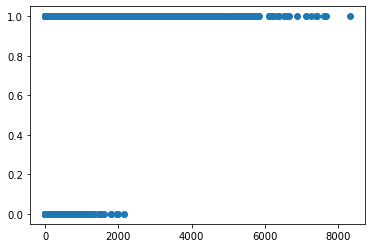

In [87]:
plt.scatter(x="amount", y="fraud", data=df)

As we see the transactions with high amount are more likley be fraudulant, however comparing the amounts of 2 transactions for different customers doesn't sound right since the value of the transactions amounts vary from customer to other and ehat considered low for one customer could be high for another one's so let us compare the transactions for each customer by dividing the transaction value for each customer by maximum transaction amount which belong to the same customer, this apprach will enable the model to figure out the abnormal behavoiur for each customer transaction, the good thing that this dataset has 4112 customers and each one has many transactions, by standrazied the transaction amount in this way then each transaction amount will be between 0 and 1 

In [95]:
# let us confirm if all customers have multiple transactions

print('Number of duplicated rows: {}.'.format(df['customer'].duplicated().shape)) # Yes all customers have multiple transactions

Number of duplicated rows: (594643,).


Block of below code will standardize the amount for each transactions as explained above

In [3]:
# intiate dictionary to store the maximum transaction amount for each customer
amount_df = df[['customer','amount']].groupby('customer').max().reset_index()
Max_amount = {}
     
for i,row in amount_df.iterrows():
    Max_amount[row.customer] = row.amount

# dividing the value for each transaction by maximum transaction amount for the same customer        
for i,row in df.iterrows():
    df.at[i,'amount'] = df.at[i,'amount']/Max_amount[row.customer]

df

,step,customer,age,gender,zipcodeOri,merchant,zipMerchant,category,amount,fraud
0,0,'C1093826151','4','M','28007','M348934600','28007','es_transportation',0.047440,0
1,0,'C352968107','2','M','28007','M348934600','28007','es_transportation',0.292065,0
2,0,'C2054744914','4','F','28007','M1823072687','28007','es_transportation',0.141832,0
3,0,'C1760612790','3','M','28007','M348934600','28007','es_transportation',0.106167,0
4,0,'C757503768','5','M','28007','M348934600','28007','es_transportation',0.212051,0
...,...,...,...,...,...,...,...,...,...,...
594638,179,'C1753498738','3','F','28007','M1823072687','28007','es_transportation',0.082354,0
594639,179,'C650108285','4','F','28007','M1823072687','28007','es_transportation',0.286740,0
594640,179,'C123623130','2','F','28007','M349281107','28007','es_fashion',0.107828,0
594641,179,'C1499363341','5','M','28007','M1823072687','28007','es_transportation',0.163464,0


In [4]:
# Confirm if all records are processed 
len(Max_amount)

4112

2- Gender, let us see if one gender has preference based on number of fraudulent transactions

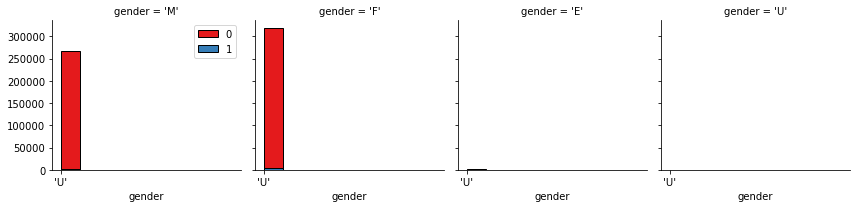

In [96]:
bins = np.linspace(df.step.min(), df.step.max(), 10)
g = sns.FacetGrid(df, col="gender", hue="fraud", palette="Set1", col_wrap=4)
g.map(plt.hist,'gender', bins=bins, ec="k")

g.axes[0].legend()
plt.show()

Comparing to the number numbers of males and females it looks there is littel bit preference for Female gender

3- Category

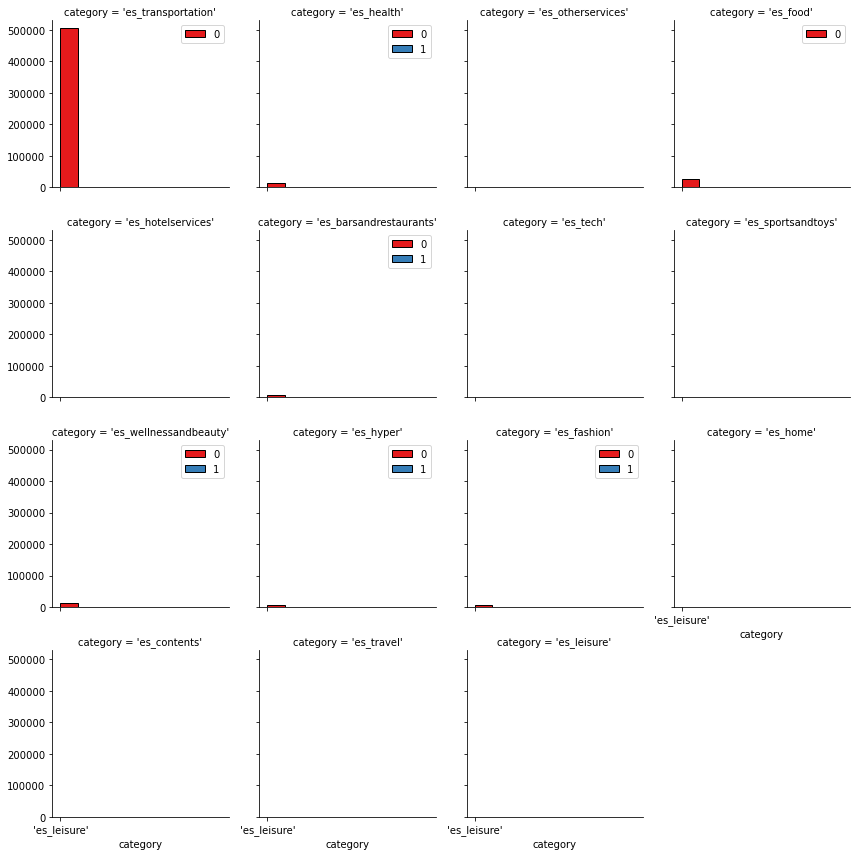

In [97]:
bins = np.linspace(df.step.min(), df.step.max(), 10)
g = sns.FacetGrid(df, col="category", hue="fraud", palette="Set1", col_wrap=4)
g.map(plt.hist,'category', bins=bins, ec="k")

g.axes[0].legend()
g.axes[1].legend()
g.axes[3].legend()
g.axes[5].legend()
g.axes[8].legend()
g.axes[9].legend()
g.axes[10].legend()
plt.show()

We can see there are some categories where most of fradulent transactions fall under them

4- Age

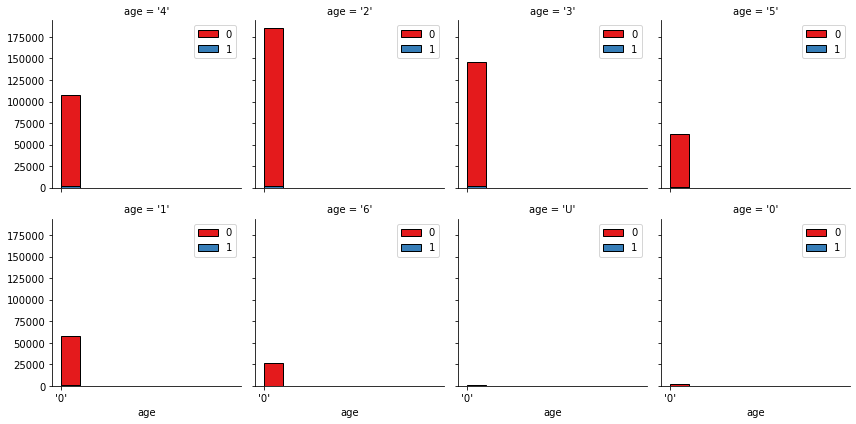

In [106]:
bins = np.linspace(df.step.min(), df.step.max(), 10)
g = sns.FacetGrid(df, col="age", hue="fraud", palette="Set1", col_wrap=4)
g.map(plt.hist,'age', bins=bins, ec="k")

g.axes[0].legend()
g.axes[1].legend()
g.axes[2].legend()
g.axes[3].legend()
g.axes[4].legend()
g.axes[5].legend()
g.axes[6].legend()
g.axes[7].legend()
plt.show()

All ages have fraudulent transactions

Looks like all ages have fraudulent transactions

5- Merchant

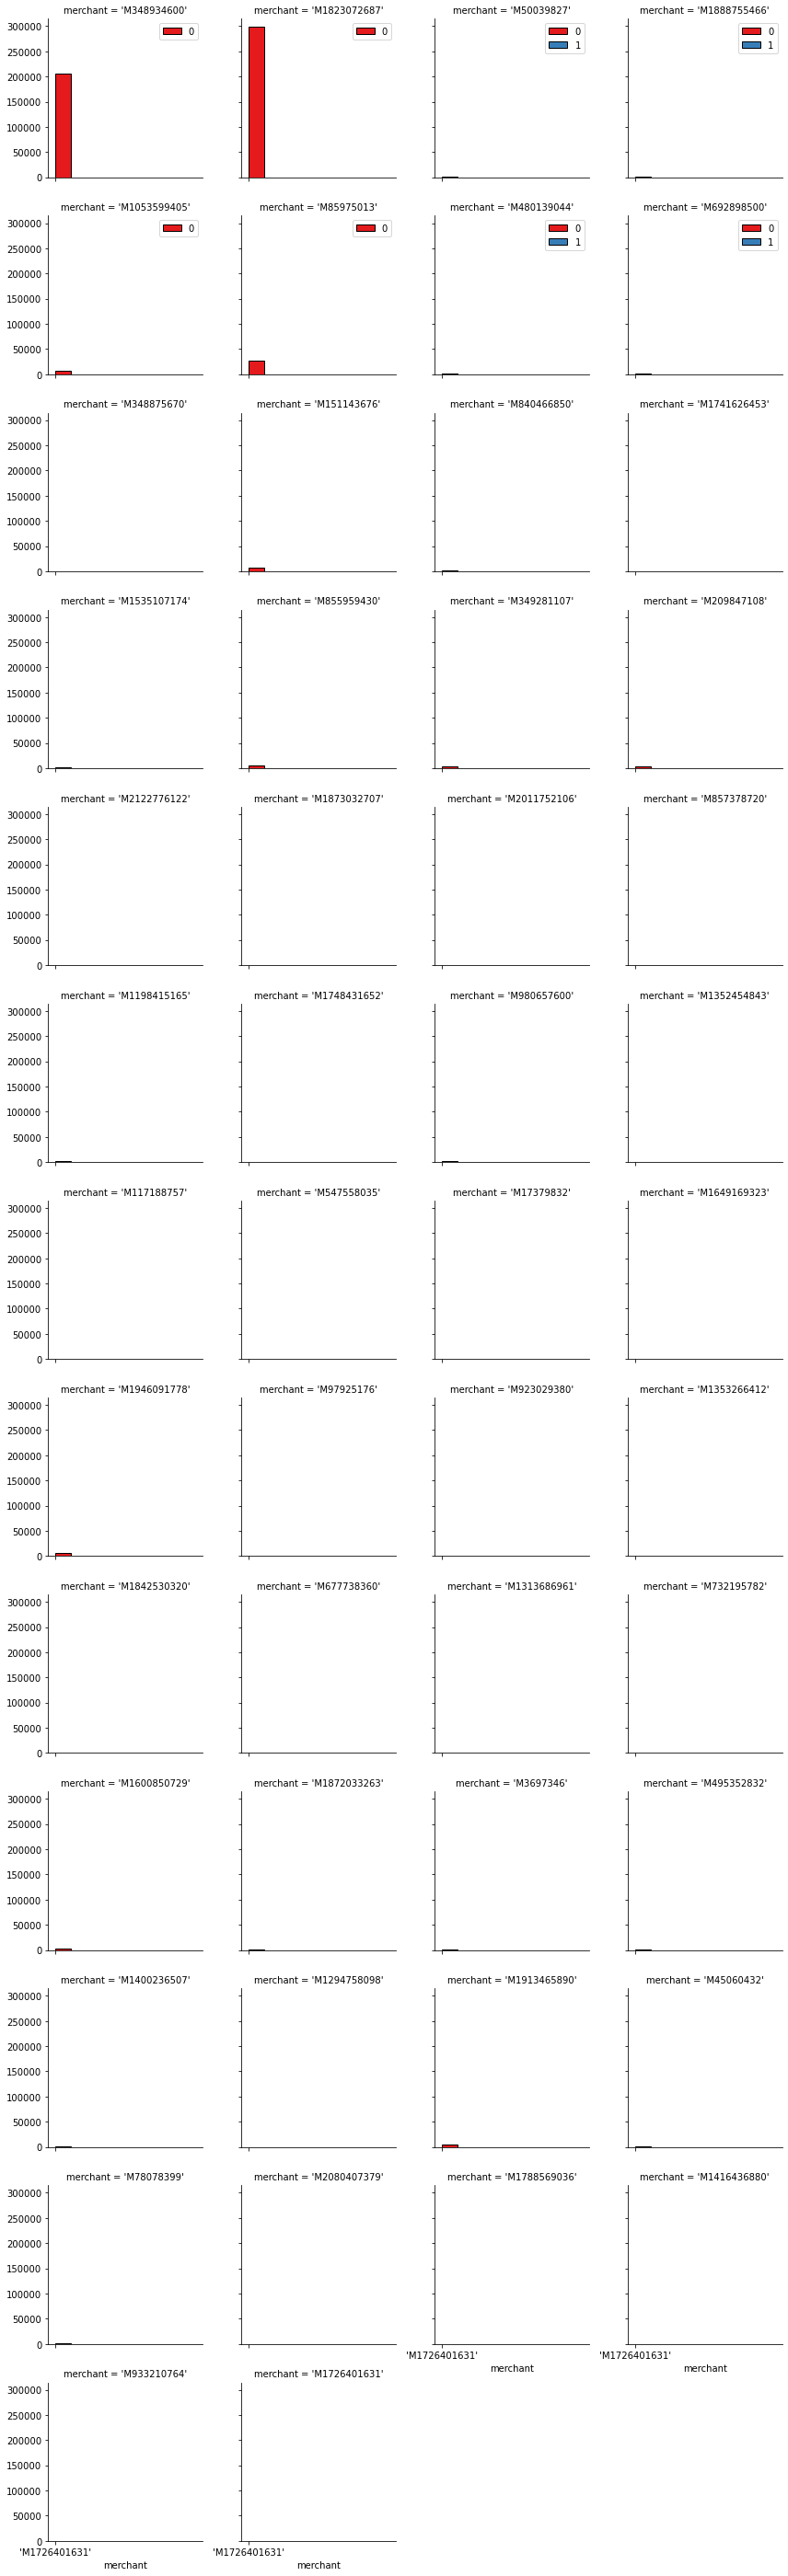

In [110]:
bins = np.linspace(df.step.min(), df.step.max(), 10)
g = sns.FacetGrid(df, col="merchant", hue="fraud", palette="Set1", col_wrap=4)
g.map(plt.hist,'merchant', bins=bins, ec="k")

g.axes[0].legend()
g.axes[1].legend()
g.axes[2].legend()
g.axes[3].legend()
g.axes[4].legend()
g.axes[5].legend()
g.axes[6].legend()
g.axes[7].legend()

plt.show()

In [ ]:
6-step

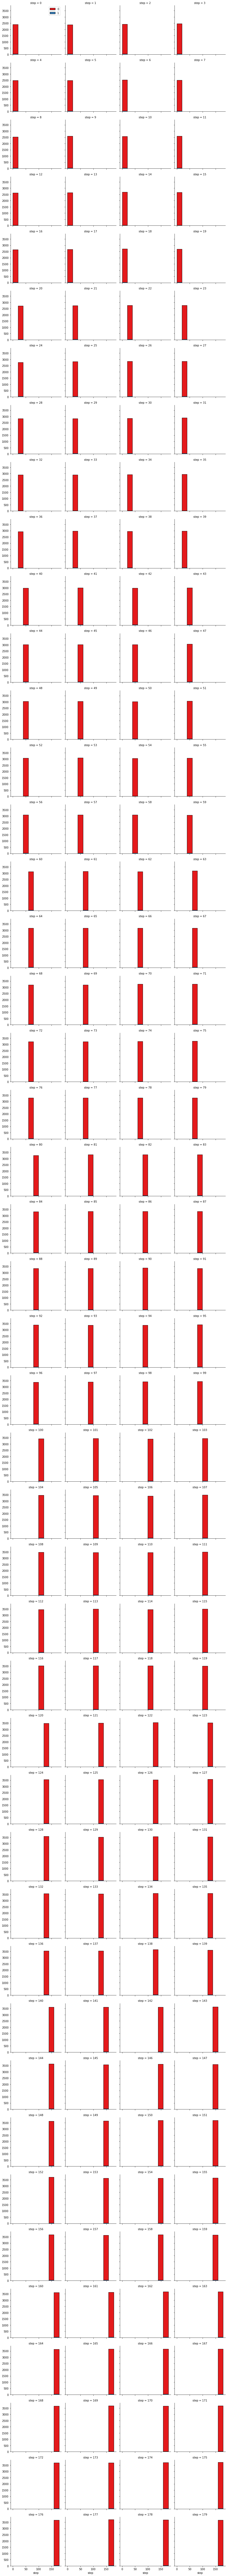

In [113]:
bins = np.linspace(df.step.min(), df.step.max(), 10)
g = sns.FacetGrid(df, col="step", hue="fraud", palette="Set1", col_wrap=4)
g.map(plt.hist,'step', bins=bins, ec="k")

g.axes[0].legend()

We see that all steps have approxiamtly the same ratio of fraudulent transactions

whereas merchants with high number of transactions have no fraudulent transactions, the other merchants with low number of transactions have high number of fraudulent transactions

<a name='DataProcessing' />
Data Processing

Check if there is any null value in dataframe

In [6]:
df.isna().sum()

step           0
customer       0
age            0
gender         0
zipcodeOri     0
merchant       0
zipMerchant    0
category       0
amount         0
fraud          0
dtype: int64

Remove the characters from category,merchant and customer columns

In [5]:
for i,row in df.iterrows():
    df.at[i,'category'] = row.category[4:-1]
    df.at[i,'merchant'] = row.merchant[2:-1]
    df.at[i,'customer'] = row.customer[2:-1]
df

,step,customer,age,gender,zipcodeOri,merchant,zipMerchant,category,amount,fraud
0,0,1093826151,'4','M','28007',348934600,'28007',transportation,0.047440,0
1,0,352968107,'2','M','28007',348934600,'28007',transportation,0.292065,0
2,0,2054744914,'4','F','28007',1823072687,'28007',transportation,0.141832,0
3,0,1760612790,'3','M','28007',348934600,'28007',transportation,0.106167,0
4,0,757503768,'5','M','28007',348934600,'28007',transportation,0.212051,0
...,...,...,...,...,...,...,...,...,...,...
594638,179,1753498738,'3','F','28007',1823072687,'28007',transportation,0.082354,0
594639,179,650108285,'4','F','28007',1823072687,'28007',transportation,0.286740,0
594640,179,123623130,'2','F','28007',349281107,'28007',fashion,0.107828,0
594641,179,1499363341,'5','M','28007',1823072687,'28007',transportation,0.163464,0


Change the "U" to 2 in age column

In [7]:
df['age'].replace({"'U'": "'2'"},inplace=True)

Change the "U" to "M" in gender column

In [8]:
df['gender'].replace({"'U'":"'M'"},inplace=True)

Change the type of customer column to float

In [9]:
df['customer'] = df['customer'].astype('float64')

Customer id/ maximum customer id

In [10]:
df['customer'] = df['customer']/df['customer'].max()

Remove the columns becuase zipcodeOri and zipmerchant have one value for each one of them becuase they are neutral<br>
step also is neutral because the distribution for fraudulent transactions are symmetrical among different steps

In [12]:
df.drop(['zipcodeOri', 'zipMerchant','step'],axis=1,inplace=True)

<a name='hotencoding'/>
Hot Encoding

In [13]:
df = pd.get_dummies(df, columns = ['gender'])
df = pd.get_dummies(df, columns = ['category'])
df = pd.get_dummies(df, columns = ['merchant'])
df = pd.get_dummies(df, columns = ['age'])

In [14]:
df.head(2)

,customer,amount,fraud,gender_'E',gender_'F',gender_'M',category_barsandrestaurants,category_contents,category_fashion,category_food,...,merchant_933210764,merchant_97925176,merchant_980657600,age_'0',age_'1',age_'2',age_'3',age_'4',age_'5',age_'6'
0,0.509720,0.047440,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0.164482,0.292065,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [15]:
# Check the number of columns (features) after hot encoding
len(df.columns)

78

<a name='splitingdata'/>
Spliting Data

Extract approximately 20% percent of dataset for production to simulate the actual data and will be used to test the model, This dataset is different than testing dataset which also used for purpose of testing the model

In [16]:
df_training = df.iloc[0:500000,:]
df_production = df.iloc[500000:594643,:]

In [17]:
# check the shape for production dataset
df_production.shape

(94643, 78)

In [18]:
# Check the number of fraudulent transactions in training and testing dataset
df_training.loc[df_training['fraud'] == 1].shape

(6180, 78)

In [19]:
# Check the number of fraudulent transactions in the production dataset
df_production.loc[df_production['fraud'] == 1].shape

(1020, 78)

<a name='Trainingdataset'/>
Training Dataset

In [20]:
X = df_training[['customer', 'amount', "gender_'F'", "gender_'M'","gender_'E'",
       'category_barsandrestaurants', 'category_contents', 'category_fashion',
       'category_food', 'category_health', 'category_home',
       'category_hotelservices', 'category_hyper', 'category_leisure',
       'category_otherservices', 'category_sportsandtoys', 'category_tech',
       'category_transportation', 'category_travel',
       'category_wellnessandbeauty', 'merchant_1053599405',
       'merchant_117188757', 'merchant_1198415165', 'merchant_1294758098',
       'merchant_1313686961', 'merchant_1352454843', 'merchant_1353266412',
       'merchant_1400236507', 'merchant_1416436880', 'merchant_151143676',
       'merchant_1535107174', 'merchant_1600850729', 'merchant_1649169323',
       'merchant_1726401631', 'merchant_17379832', 'merchant_1741626453',
       'merchant_1748431652', 'merchant_1788569036', 'merchant_1823072687',
       'merchant_1842530320', 'merchant_1872033263', 'merchant_1873032707',
       'merchant_1888755466', 'merchant_1913465890', 'merchant_1946091778',
       'merchant_2011752106', 'merchant_2080407379', 'merchant_209847108',
       'merchant_2122776122', 'merchant_348875670', 'merchant_348934600',
       'merchant_349281107', 'merchant_3697346', 'merchant_45060432',
       'merchant_480139044', 'merchant_495352832', 'merchant_50039827',
       'merchant_547558035', 'merchant_677738360', 'merchant_692898500',
       'merchant_732195782', 'merchant_78078399', 'merchant_840466850',
       'merchant_855959430', 'merchant_857378720', 'merchant_85975013',
       'merchant_923029380', 'merchant_933210764', 'merchant_97925176',
       'merchant_980657600', "age_'0'", "age_'1'", "age_'2'", "age_'3'",
       "age_'4'", "age_'5'", "age_'6'"]]

In [21]:
y = df_training['fraud']

In [22]:
X_prod = df_production[['customer', 'amount', "gender_'F'", "gender_'M'", "gender_'E'",
       'category_barsandrestaurants', 'category_contents', 'category_fashion',
       'category_food', 'category_health', 'category_home',
       'category_hotelservices', 'category_hyper', 'category_leisure',
       'category_otherservices', 'category_sportsandtoys', 'category_tech',
       'category_transportation', 'category_travel',
       'category_wellnessandbeauty', 'merchant_1053599405',
       'merchant_117188757', 'merchant_1198415165', 'merchant_1294758098',
       'merchant_1313686961', 'merchant_1352454843', 'merchant_1353266412',
       'merchant_1400236507', 'merchant_1416436880', 'merchant_151143676',
       'merchant_1535107174', 'merchant_1600850729', 'merchant_1649169323',
       'merchant_1726401631', 'merchant_17379832', 'merchant_1741626453',
       'merchant_1748431652', 'merchant_1788569036', 'merchant_1823072687',
       'merchant_1842530320', 'merchant_1872033263', 'merchant_1873032707',
       'merchant_1888755466', 'merchant_1913465890', 'merchant_1946091778',
       'merchant_2011752106', 'merchant_2080407379', 'merchant_209847108',
       'merchant_2122776122', 'merchant_348875670', 'merchant_348934600',
       'merchant_349281107', 'merchant_3697346', 'merchant_45060432',
       'merchant_480139044', 'merchant_495352832', 'merchant_50039827',
       'merchant_547558035', 'merchant_677738360', 'merchant_692898500',
       'merchant_732195782', 'merchant_78078399', 'merchant_840466850',
       'merchant_855959430', 'merchant_857378720', 'merchant_85975013',
       'merchant_923029380', 'merchant_933210764', 'merchant_97925176',
       'merchant_980657600', "age_'0'", "age_'1'", "age_'2'", "age_'3'",
       "age_'4'", "age_'5'", "age_'6'"]]

In [23]:
y_prod = df_production['fraud']

<a name ='oversampling'/>
Oversampling

Oversampling aims to increase the number of fraudulent transactions to be close to the number of truthfull transactions, this process is high requiered to balance the data, without balancing the data, model will be more more biosed to truthfull transaction and less sensitive to fraudulent transactions and you will end up with model with low accuracy 

In [24]:
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)

In [25]:
# number of records have been doubeld 
X_res.shape

(987640, 77)

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X_res,y_res,test_size=0.3,random_state=42,stratify=y_res)

Different models will be evaluted to choose the optimal one

<a name='catboost'/>
CatBoost

-Accuracy(by using testing dataset) = 96% <br>
-Accuracy(by using production dataset) = 94% <br>
-1020 fraud transactions out of 1020 fraud transactions have been classified correctly by model! <br>
-5534 true transactions out of 93623 true transactions have been classied by model as fraud transactions<br>
-Estimated time to proceed production dataset consist of 94643 rows is 0.028914451599121094s (time slightly varies from one run to another)

In [36]:
# building the model
test_data = catboost_pool = Pool(X_test,y_test)

model = CatBoostClassifier(iterations=2,
                           depth=2,
                           learning_rate=1,
                           loss_function='Logloss',
                           verbose=True)
# train the model
model.fit(X_train, y_train)
# make the prediction using the resulting model
yhat = model.predict(test_data)
preds_proba = model.predict_proba(test_data)
print("class = ", yhat)
print("proba = ", preds_proba)
print("Classification Report for CatBoost: \n", classification_report(y_test, yhat))

0:	learn: 0.1645719	total: 166ms	remaining: 166ms
1:	learn: 0.1397224	total: 300ms	remaining: 0us
class =  [1 0 0 ... 1 1 0]
proba =  [[7.22e-02 9.28e-01]
 [1.00e+00 2.38e-05]
 [1.00e+00 1.05e-04]
 ...
 [7.22e-02 9.28e-01]
 [7.22e-02 9.28e-01]
 [1.00e+00 2.38e-05]]
Classification Report for CatBoost: 
               precision    recall  f1-score   support

           0       1.00      0.92      0.96    148146
           1       0.93      1.00      0.96    148146

    accuracy                           0.96    296292
   macro avg       0.96      0.96      0.96    296292
weighted avg       0.96      0.96      0.96    296292



Classification Report for CatBoost: 
               precision    recall  f1-score   support

           0       1.00      0.94      0.97     93623
           1       0.16      1.00      0.27      1020

    accuracy                           0.94     94643
   macro avg       0.58      0.97      0.62     94643
weighted avg       0.99      0.94      0.96     94643

Duration: 0.02988576889038086.
Confusion matrix, without normalization
[[ 1020     0]
 [ 5534 88089]]


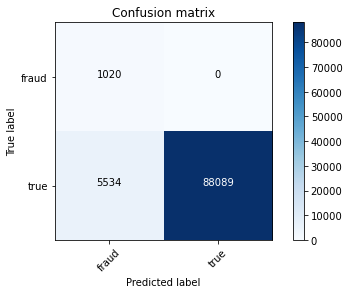

In [34]:
# Evalute the model
time_zero = time.time()
prod_data = catboost_pool = Pool(X_prod)
yhatCat = model.predict(prod_data)
duration = time.time() - time_zero
print("Classification Report for CatBoost: \n", classification_report(y_prod, yhatCat))
print('Duration: {}.'.format(duration))
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_prod, yhatCat, labels=[1,0])
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['fraud','true'],normalize= False,  title='Confusion matrix')

<a name='adaboost'/>
 AdaBoost

-Accuracy(by using testing dataset) = 98% <br>
-Accuracy(by using production dataset) = 98% <br>
-1003 fraud transactions out of 1020 fraud transactions have been classified correctly by model! <br>
-2335 true transactions out of 93623 true transactions have been classied by model as fraud transactions<br>
-Estimated time to proceed production dataset consist of 94643 rows is 5.924099922180176s (time slightly varies from one run to another)

In [39]:
# building the model
clf = AdaBoostClassifier(n_estimators=100, random_state=0)
clf.fit(X_train, y_train)
yhat = clf.predict(X_test)
print("Classification Report for AdaBoost: \n", classification_report(y_test, yhat))

Classification Report for AdaBoost: 
               precision    recall  f1-score   support

           0       1.00      0.95      0.97    148146
           1       0.96      1.00      0.98    148146

    accuracy                           0.98    296292
   macro avg       0.98      0.98      0.98    296292
weighted avg       0.98      0.98      0.98    296292



Classification Report for AdaBoost: 
               precision    recall  f1-score   support

           0       1.00      0.98      0.99     93623
           1       0.30      0.98      0.46      1020

    accuracy                           0.98     94643
   macro avg       0.65      0.98      0.72     94643
weighted avg       0.99      0.98      0.98     94643

Duration: 5.924099922180176.
Confusion matrix, without normalization
[[ 1003    17]
 [ 2335 91288]]


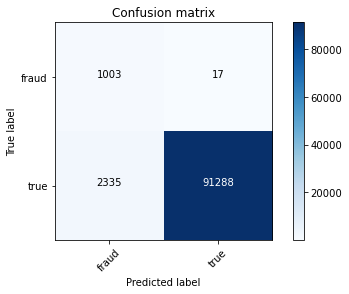

In [40]:
# Evalute the model
time_zero = time.time()
yhatAda = clf.predict(X_prod)
duration = time.time() - time_zero
print("Classification Report for AdaBoost: \n", classification_report(y_prod, yhatAda))
print('Duration: {}.'.format(duration))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_prod, yhatAda, labels=[1,0])
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['fraud','true'],normalize= False,  title='Confusion matrix')

<a name='lgbboost'/>
LGBBoost

-Accuracy(by using testing dataset) = 98%<br>
-Accuracy(by using production dataset) = 98%<br>
-990 fraud transactions out of 1020 fraud transactions have been classified correctly by model<br>
-2004 true transactions out of 93623 true transactions have been classied by model as fraud transactions<br>
-Estimated time to proceed production dataset consist of 94643 rows is 0.18203353881835938s (time slightly varies from one run to another)

In [41]:
# building the model
time_zero = time.time()

lgbm = LGBMClassifier()

lgbm.fit(X_train,y_train)

yhat = lgbm.predict(X_test)


duration = time.time() - time_zero

print("Classification Report for LGBBoost: \n", classification_report(y_test, yhat))

print('Duration: {}.'.format(duration))


Classification Report for LGBBoost: 
               precision    recall  f1-score   support

           0       1.00      0.96      0.98    148146
           1       0.96      1.00      0.98    148146

    accuracy                           0.98    296292
   macro avg       0.98      0.98      0.98    296292
weighted avg       0.98      0.98      0.98    296292

Duration: 5.195340871810913.


Classification Report for LgbBoost: 
               precision    recall  f1-score   support

           0       1.00      0.98      0.99     93623
           1       0.33      0.97      0.49      1020

    accuracy                           0.98     94643
   macro avg       0.67      0.97      0.74     94643
weighted avg       0.99      0.98      0.98     94643

Duration: 0.18203353881835938.
Confusion matrix, without normalization
[[  990    30]
 [ 2004 91619]]


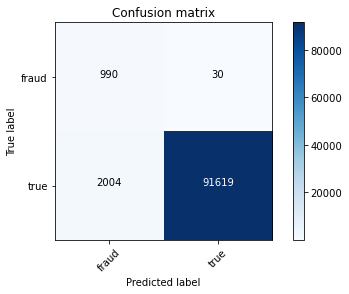

In [42]:
# Evalute the model
time_zero = time.time()
yhatLgb = lgbm.predict(X_prod)
duration = time.time() - time_zero
print("Classification Report for LgbBoost: \n", classification_report(y_prod, yhatLgb))
print('Duration: {}.'.format(duration))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_prod, yhatLgb, labels=[1,0])
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['fraud','true'],normalize= False,  title='Confusion matrix')

<a name='xgbboost'/>
XGBBoost

-Accuracy(by using testing dataset) = 98%<br>
-Accuracy(by using production dataset) = 98%<br>
-990 fraud transactions out of 1020 fraud transactions have been classified correctly by model<br>
-2262 true transactions out of 93623 true transactions have been classied by model as fraud transactions<br>
-Estimated time to proceed production dataset consist of 94643 rows is 0.5125706195831299s (time slightly varies from one run to another)

In [43]:
# Building the model
XGBoost_CLF = xgb.XGBClassifier(max_depth=6, learning_rate=0.05, n_estimators=400, 
                                objective="binary:hinge", booster='gbtree', 
                                n_jobs=-1, nthread=None, gamma=0, min_child_weight=1, max_delta_step=0, 
                                subsample=1, colsample_bytree=1, colsample_bylevel=1, reg_alpha=0, reg_lambda=1, 
                                scale_pos_weight=1, base_score=0.5, random_state=42, verbosity=1)

time_zero = time.time()
XGBoost_CLF.fit(X_train,y_train)

yhat = XGBoost_CLF.predict(X_test)
duration = time.time() - time_zero

print("Classification Report for XGBoost: \n", classification_report(y_test, yhat))
print('Duration: {}.'.format(duration))

C:\Users\stum2013148992\Anaconda3\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:32:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Classification Report for XGBoost: 
               precision    recall  f1-score   support

           0       1.00      0.96      0.98    148146
           1       0.96      1.00      0.98    148146

    accuracy                           0.98    296292
   macro avg       0.98      0.98      0.98    296292
weighted avg       0.98      0.98      0.98    296292

Duration: 669.5492513179779.


Classification Report for XGBoost: 
               precision    recall  f1-score   support

           0       1.00      0.98      0.99     93623
           1       0.30      0.97      0.46      1020

    accuracy                           0.98     94643
   macro avg       0.65      0.97      0.73     94643
weighted avg       0.99      0.98      0.98     94643

Duration: 0.5125706195831299.
Confusion matrix, without normalization
[[  990    30]
 [ 2262 91361]]


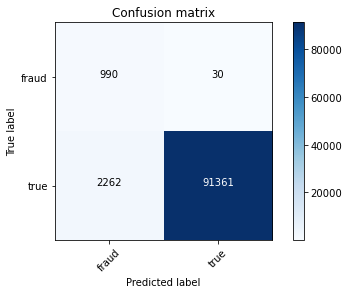

In [44]:
# Evalute the model
time_zero = time.time()
yhatXgb = XGBoost_CLF.predict(X_prod)
duration = time.time() - time_zero
print("Classification Report for XGBoost: \n", classification_report(y_prod, yhatXgb))
print('Duration: {}.'.format(duration))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_prod, yhatXgb, labels=[1,0])
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['fraud','true'],normalize= False,  title='Confusion matrix')

<a name='knn'/>
KNeighbors

-Accuracy(by using testing dataset) = 99%<br>
-Accuracy(by using production dataset) = 99%<br>
-930 fraud transactions out of 1020 fraud transactions have been classified correctly by model<br>
-1317 true transactions out of 93623 true transactions have been classied by model as fraud transactions<br>
-Estimated time to proceed production dataset consist of 94643 rows is 1856.4180331230164s (time slightly varies from one run to another)

In [ ]:
# build the model
knn = KNeighborsClassifier(n_neighbors=7,p=1)
time_zero = time.time()
knn.fit(X_train,y_train)
yhat = knn.predict(X_test)
duration = time.time() - time_zero

print("Classification Report for K-Nearest Neighbours: \n", classification_report(y_test, yhat))
print('The estimated excution time: {}.'.format(duration))

In [45]:
# Evalute the model
time_zero = time.time()
yhatKNN = knn.predict(X_prod)
duration = time.time() - time_zero
print("Classification Report for XGBoost: \n", classification_report(y_prod, yhatKNN))
print('The estimated excution time: {}.'.format(duration))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_prod, yhatKNN, labels=[1,0])
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['fraud','true'],normalize= False,  title='Confusion matrix')

NameError: name 'knn' is not defined

In [ ]:
# Plot confusion matrix function:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    yhatM = classes
    y_prod = cm
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

print(confusion_matrix(y_prod,yhatM, labels=[1,0]))

<a name='results'/>
Results

<table>
  <thead>
    <tr>
      <th>Model Name</th>
      <th>Accuracy%(Using production Dataset)</th>
      <th>Number of true predicted fraud transactions (Out of 1020)</th>
      <th>Number of wrong predicted fraud transactions (Out of 93623)</th>
       <th>Latency(s)</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>CatBoost</td>
      <td>94%</td>
      <td>1020</td>
      <td>5534</td>
      <td>0.028914451599121094</td>
    </tr>
    <tr>
      <td>AdaBoost</td>
      <td>98%</td>
      <td>1003</td>
      <td>2335</td>
      <td>5.924099922180176</td>
    </tr>
    <tr>
      <td>LGBBoost</td>
      <td>98%</td>
      <td>990</td>
      <td>2004</td>
      <td>0.18203353881835938</td>
    </tr>
    <tr>
      <td>XGBBoost</td>
      <td>98%</td>
      <td>990</td>
      <td>2262</td>
      <td>0.5125706195831299</td>
    </tr>
    <tr>
      <td>KNeighbors</td>
      <td>99%</td>
      <td>930</td>
      <td>1317</td>
      <td>1856.4180331230164</td>
    </tr>
  </tbody>
</table>

<b>CatBoost:</b><br>
-Accuracy(by using testing dataset) = 96% <br>
-Accuracy(by using production dataset) = 94% <br>
-1020 fraud transactions out of 1020 fraud transactions have been classified correctly by model<br>
-5534 true transactions out of 93623 true transactions have been classied by model as fraud transactions<br>
-Estimated time to proceed production dataset consist of 94643 rows is 0.028914451599121094s (time slightly varies from one run to another)
<br><br>

<b>AdaBoost:</b><br>
-Accuracy(by using testing dataset) = 98% <br>
-Accuracy(by using production dataset) = 98% <br>
-1003 fraud transactions out of 1020 fraud transactions have been classified correctly by model! <br>
-2335 true transactions out of 93623 true transactions have been classied by model as fraud transactions<br>
-Estimated time to proceed production dataset consist of 94643 rows is 5.924099922180176s (time slightly varies from one run to another)

<br><br>

<b>LGBBoost:</b><br>
-Accuracy(by using testing dataset) = 98%<br>
-Accuracy(by using production dataset) = 98%<br>
-990 fraud transactions out of 1020 fraud transactions have been classified correctly by model<br>
-2004 true transactions out of 93623 true transactions have been classied by model as fraud transactions<br>
-Estimated time to proceed production dataset consist of 94643 rows is 0.18203353881835938s (time slightly varies from one run to another)
    
<br><br>
<b> XGBBoost:</b><br>
-Accuracy(by using testing dataset) = 98%<br>
-Accuracy(by using production dataset) = 98%<br>
-990 fraud transactions out of 1020 fraud transactions have been classified correctly by model<br>
-2262 true transactions out of 93623 true transactions have been classied by model as fraud transactions<br>
-Estimated time to proceed production dataset consist of 94643 rows is 0.5125706195831299s (time slightly varies from one run to another)

<br><br>
<b>KNeighbors:</b><br>
-Accuracy(by using testing dataset) = 99%<br>
-Accuracy(by using production dataset) = 99%<br>
-930 fraud transactions out of 1020 fraud transactions have been classified correctly by model<br>
-1317 true transactions out of 93623 true transactions have been classied by model as fraud transactions<br>
-Estimated time to proceed production dataset consist of 94643 rows is 1856.4180331230164s (time slightly varies from one run to another)

<a name='discussion'/>
Discussion

1- KNeighbors excution time is so high, it took around 31 minuites to predict the ststus of production transactions(93623 rows) wso it's not the optimal option comparing with other models.<br>
2-Though Catboost has the minimum latecy and it has predicted all fraud transactions however it has predecited 5534 true transactions out of 93623 true transactions as fraud transactions which unfortunatly reduced its accuracy and move it away from top of list<br>
3-XGBBoost and LGBBoost have predicted correctly 990 fraudulent transactions out of 1020 fradulent transactions however XGBBoost latency time is more than LGBBoost and it has predicted 2264 true transactions as fraudulent transactions whereas LGB has predicted 2004 true transactions as fraudulent transactions which gives LGBBoost preference over XGBBoost<br>
4- AdaBoost and LGBBoost are similar, LGBBoost latency is better than AdaBoost on the other hand AdaBoost has predicted correctly more fraudulent transactions than LGBBoost which make both of them are the optimal option.

<a name='recomendation'/>
Recomendation

AdaBoost and LGBBoost are the recomended models for this dataset